# Bridge Dataset

## Get Dataset

In [6]:
import os 
from  pylabel import importer
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd

import random
import albumentations as A
from tqdm import tqdm
from pathlib import *

/Users/apple/builds/research/bridge_vision/venv/lib/python3.11/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
  data = fetch_version_info()


In [7]:
data_path = Path("bridge_dataset")
annotations_path = data_path / "Annotations"
images_path = data_path / "JPEGImages"

In [8]:
len(os.listdir(annotations_path))

3685

In [9]:
len(os.listdir(images_path))

3685

### Sample Annotation

In [10]:
print(os.path.join(annotations_path, sorted(os.listdir(annotations_path))[1]))
with open(os.path.join(annotations_path, sorted(os.listdir(annotations_path))[1])) as file:
    print(' '.join(file.readlines()))

bridge_dataset/Annotations/aug_0_0_image_0000936.xml
<annotation>
 	<folder>set6</folder>
 	<filename>aug_0_0_image_0000936.jpg</filename>
 	<size>
 		<width>640</width>
 		<height>640</height>
 		<depth>3</depth>
 	</size>
 	<object>
 		<name>CorrosionStain</name>
 		<difficult>0</difficult>
 		<bndbox>
 			<xmin>172</xmin>
 			<ymin>127</ymin>
 			<xmax>250</xmax>
 			<ymax>325</ymax>
 		</bndbox>
 		</object>
 	<object>
 		<name>CorrosionStain</name>
 		<difficult>0</difficult>
 		<bndbox>
 			<xmin>287</xmin>
 			<ymin>279</ymin>
 			<xmax>338</xmax>
 			<ymax>418</ymax>
 		</bndbox>
 		</object>
 </annotation>


### Extract Classes

In [11]:
classes = set()
annotations = os.listdir(annotations_path)

for file in annotations:
    if file.endswith(".xml"):
        tree = ET.parse(os.path.join(annotations_path, file))
        root = tree.getroot()
        for obj in root.findall("object"):
            classes.add(obj.find("name").text) 
classes

{'Cavity',
 'CorrosionStain',
 'Crack',
 'Efflorescence',
 'ExposedBars',
 'Spallation',
 'Voids',
 'Water'}

In [12]:
category_id_to_name = {1:'Cavity',
 2:'CorrosionStain',
 3:'Crack',
 4:'Efflorescence',
 5:'ExposedBars',
 6:'Spallation',
 7:'Voids',
 8:'Water'
 }

In [13]:
f"Number of classes {len(classes)}"

'Number of classes 8'

### Parse Annotations

In [14]:
from collections import Counter

def get_class_counts():
    objects = []
    class_count = Counter()
    annotations_count = 0

    for file in os.listdir(annotations_path):
        if file.endswith(".xml"):
            tree = ET.parse(os.path.join(annotations_path, file))
            root = tree.getroot()
            objs = []
  
            for obj in root.findall("object"):
                annotations_count +=1
                xmin = int(obj.find("bndbox").find("xmin").text)
                ymin = int(obj.find("bndbox").find("ymin").text)
                xmax = int(obj.find("bndbox").find("xmax").text)
                ymax = int(obj.find("bndbox").find("ymax").text)
                objs.append({"box":[xmin, ymin, xmax, ymax],"class":obj.find("name").text, "image": root.find("filename").text})
  
            objects.append(objs)

    for items in objects:
        for item in items:
            class_count[item["class"]] += 1
    return class_count


In [15]:
objects = []
image_dims = []
objects_per_image = []
annotations_count = 0
bbox_dims = []
bbox_ratios = []
bbox_areas = []
images = []
bbox_image_area_ratio = []

for file in annotations:
    if file.endswith(".xml"):
        tree = ET.parse(os.path.join(annotations_path, file))
        root = tree.getroot()
        objs = []
        images.append(root.find("filename").text)
        height = int(root.find("size/height").text)
        width = int(root.find("size/width").text)
        depth = int(root.find("size/depth").text)
        image_size = height * width
       
     
        for obj in root.findall("object"):
            bbox_size = 0
            annotations_count +=1
            xmin = int(obj.find("bndbox").find("xmin").text)
            ymin = int(obj.find("bndbox").find("ymin").text)
            xmax = int(obj.find("bndbox").find("xmax").text)
            ymax = int(obj.find("bndbox").find("ymax").text)
            objs.append({"box":[xmin, ymin, xmax, ymin],"class":obj.find("name").text, "image": root.find("filename").text})
            b_width = xmax - xmin 
            b_height = ymax - ymin 
            bbox_dims.append([b_width, b_height])
            if b_height > 0:
                bbox_ratios.append(b_width/ b_height)
            bbox_size = b_width * b_height
            bbox_areas.append(bbox_size)
            bbox_image_area_ratio.append({"value":bbox_size/image_size, "image": root.find("filename").text})

        objects_per_image.append({"Image":root.find("filename").text ,"objects":len(objs)})
  
        image_dims.append([width, height, depth])
        objects.append(objs)

In [16]:
objects[0], len(objects)

([{'box': [58, 425, 306, 425],
   'class': 'Water',
   'image': 'aug_23_3_image_0002106.jpg'},
  {'box': [310, 425, 559, 425],
   'class': 'Water',
   'image': 'aug_23_3_image_0002106.jpg'},
  {'box': [101, 342, 343, 342],
   'class': 'Spallation',
   'image': 'aug_23_3_image_0002106.jpg'},
  {'box': [478, 265, 545, 265],
   'class': 'ExposedBars',
   'image': 'aug_23_3_image_0002106.jpg'},
  {'box': [426, 242, 460, 242],
   'class': 'ExposedBars',
   'image': 'aug_23_3_image_0002106.jpg'}],
 3684)

In [17]:
image_dims[0], len(image_dims)

([640, 640, 3], 3684)

In [18]:
bbox_areas = np.array(bbox_areas)
bbox_dims = np.array(bbox_dims)
bbox_ratios = np.array(bbox_ratios)
image_dims = np.array(image_dims)
objects_per_image = np.array(objects_per_image)

In [19]:


class_count = Counter()
for items in objects:
    for item in items:
        class_count[item["class"]] += 1
class_count.total()

24449

In [20]:
class_count

Counter({'Efflorescence': 5111,
         'Crack': 5096,
         'Spallation': 3781,
         'CorrosionStain': 3411,
         'Water': 3345,
         'ExposedBars': 2181,
         'Voids': 914,
         'Cavity': 610})

In [21]:
f"Number of annotations {class_count.total()}"

'Number of annotations 24449'

In [22]:
class_count

Counter({'Efflorescence': 5111,
         'Crack': 5096,
         'Spallation': 3781,
         'CorrosionStain': 3411,
         'Water': 3345,
         'ExposedBars': 2181,
         'Voids': 914,
         'Cavity': 610})

### Create Custom dataset

In [24]:
dataset_stats = {
     'total_images': len(images),
        'total_annotations': annotations_count,
        'annotations_per_class': class_count,
        'avg_objects_per_image': np.mean(np.array([item['objects'] for item in objects_per_image])),
        'min_bbox_width': np.min(bbox_dims[:, 0]) if len(bbox_dims) > 0 else 0,
        'max_bbox_width': np.max(bbox_dims[:, 0]) if len(bbox_dims) > 0 else 0,
        'avg_bbox_width': np.mean(bbox_dims[:, 0]) if len(bbox_dims) > 0 else 0,
        'min_bbox_height': np.min(bbox_dims[:, 1]) if len(bbox_dims) > 0 else 0,
        'max_bbox_height': np.max(bbox_dims[:, 1]) if len(bbox_dims) > 0 else 0,
        'avg_bbox_height': np.mean(bbox_dims[:, 1]) if len(bbox_dims) > 0 else 0,
        'min_bbox_area': np.min(bbox_areas) if len(bbox_areas) > 0 else 0,
        'max_bbox_area': np.max(bbox_areas) if len(bbox_areas) > 0 else 0,
        'avg_bbox_area': np.mean(bbox_areas) if len(bbox_areas) > 0 else 0,
        'min_image_width': np.min(image_dims[:, 0]) if len(image_dims) > 0 else 0,
        'max_image_width': np.max(image_dims[:, 0]) if len(image_dims) > 0 else 0,
        'avg_image_width': np.mean(image_dims[:, 0]) if len(image_dims) > 0 else 0,
        'min_image_height': np.min(image_dims[:, 1]) if len(image_dims) > 0 else 0,
        'max_image_height': np.max(image_dims[:, 1]) if len(image_dims) > 0 else 0,
        'avg_image_height': np.mean(image_dims[:, 1]) if len(image_dims) > 0 else 0,
}

## Visualize Dataset

### Sample Image

bridge_dataset/JPEGImages/aug_0_0_image_0000936.jpg


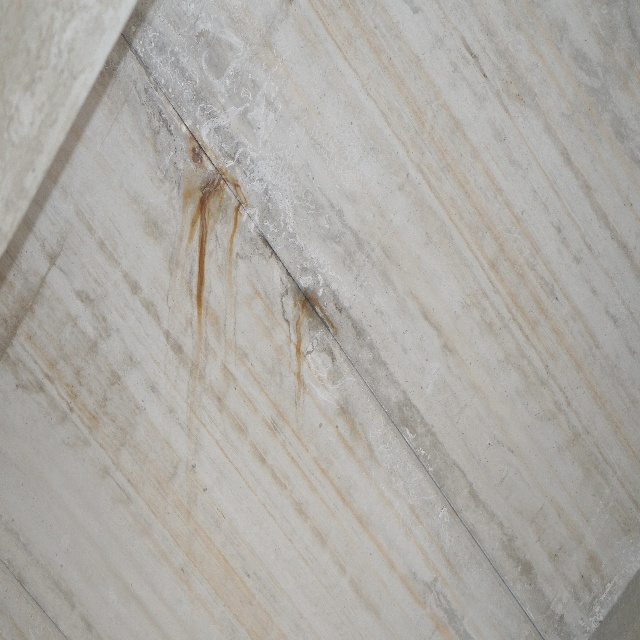

In [23]:
# Open sample image
print(os.path.join(images_path, sorted(os.listdir(images_path))[1]))
sample_image = Image.open(os.path.join(images_path, sorted(os.listdir(images_path))[1]))
sample_image

### Helper Functions

In [26]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def add_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    
    print(bbox)
    x_min, y_min, x_max, y_max,id = bbox
    class_name = category_id_to_name[int(id)]
    cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (int(x_min), int(y_min) - int(1.3 * text_height)), (int(x_min) + text_width, int(y_min)), BOX_COLOR, -1)
    print(class_name)
    cv2.putText(
        img,
        text=class_name,
        org=(int(x_min), int(y_min) - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

In [27]:
def view_image_bbox(image, bboxes):
    # img = cv2.imread(image_path / image)
    for bbox in bboxes:
        img = add_bbox(image, bbox)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [28]:
def get_key(val):
  
    for key, value in category_id_to_name.items():
        if val == value:
            return key

    return "key doesn't exist"

In [29]:
def show_transformed_image(o_image, t_image):
    fig = plt.figure(figsize=(10,7))
    fig.add_subplot(2,1,1)
    plt.title("Original Image")
    plt.imshow(o_image)
    plt.axis("off")

    fig.add_subplot(2,2,2)
    plt.title("Tranformed Image")
    plt.imshow(t_image)
    plt.axis("off")

In [30]:
def get_bounding_boxes(file, path_dir=annotations_path):
    objs = []
    class_names = []

    tree = ET.parse(path_dir / file)
    root = tree.getroot()

    img = root.find("filename").text

    for obj in root.findall("object"):
        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)
        class_name = obj.find("name").text
        class_names.append(class_name)


        objs.append([xmin, ymin, xmax, ymax, get_key(class_name)])
    return img, objs, class_names

In [31]:
def is_voc_bbox_valid(bbox, image_width, image_height):
    """
    Check if a bounding box is valid for Pascal VOC format.
    Pascal VOC format: [xmin, ymin, xmax, ymax]

    :param bbox: List or tuple with bbox coordinates in Pascal VOC format [xmin, ymin, xmax, ymax]
    :param image_width: Width of the image
    :param image_height: Height of the image
    :return: Boolean indicating if the bbox is valid
    """
    xmin, ymin, xmax, ymax = bbox

    # Check if xmin < xmax and ymin < ymax
    if xmin >= xmax or ymin >= ymax:
        return False

    # Check if bbox coordinates are within the image boundaries
    if xmin < 0 or ymin < 0 or xmax > image_width or ymax > image_height:
        return False

    return True

In [32]:
def cross_validate_dims(img, img_dims, image_path=images_path):
    img = cv2.imread(image_path /img)
    print(img_dims)
    print(img.shape)
    if not int(img.shape[1]) == img_dims[0] or not int(img.shape[0]) == img_dims[1]:
        return  False
    
    return True

In [33]:
def get_bboxes_and_img_dims(data_dir,file):
    objs = []

    tree = ET.parse(data_dir / file)
    root = tree.getroot()

    img = root.find("filename").text
    img_dims = [int(root.find("size/width").text), int(root.find("size/height").text)]

    for obj in root.findall("object"):
        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)
        class_name = obj.find("name").text

        objs.append([xmin, ymin, xmax, ymax])
    return img, objs, img_dims

### Sanity Check

In [29]:
dim_issues = []
bbox_issues = []

for ann in os.listdir(annotations_path):
    img, bboxes, img_dims = get_bboxes_and_img_dims(annotations_path,ann)

    for bbox in bboxes:
        if not cross_validate_dims(img,img_dims=img_dims):
            dim_issues.append(ann)
        if not is_voc_bbox_valid(bbox, img_dims[0], img_dims[1]):
            bbox_issues.append(ann)

[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[1024, 768]
(768, 1024, 3)
[1024, 768]
(768, 1024, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[1024, 768]
(768, 1024, 3)
[1536, 2048]
(2048, 1536, 3)
[1536, 2048]
(2048, 1536, 3)
[1024, 768]
(768, 1024, 3)
[1024, 768]
(768, 1024, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[1712, 3648]
(3648, 1712, 3)
[6000, 3376]
(3376, 6000, 3)
[6000, 3376]
(3376, 6000, 3)
[6000, 3376]
(3376, 6000, 3)
[6000, 3376]
(3376, 6000, 3)
[6000, 3376]
(3376, 6000, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608, 3)
[4608, 3456]
(3456, 4608

In [30]:
len(dim_issues)

39

In [31]:
len(bbox_issues)

0

### View Image annotations

In [44]:
def next_images(ann_files,i):
    if i < len(ann_files):
        img, bboxes, classes = get_bounding_boxes(ann_files[i])
        image = cv2.imread(images_path / img)

        print(image.shape)
        view_image_bbox(image, bboxes)

In [53]:
i = 0

In [71]:

next_images(list(set(dim_issues)), 16)

In [74]:
len(list(set(dim_issues)))

15

In [82]:
sorted(list(set(dim_issues)))

['image_0000198.xml',
 'image_0000227.xml',
 'image_0000229.xml',
 'image_0000281.xml',
 'image_0000321.xml',
 'image_0000367.xml',
 'image_0000756.xml',
 'image_0000801.xml',
 'image_0000832.xml',
 'image_0000923.xml',
 'image_0000939.xml',
 'image_0000958.xml',
 'image_0000970.xml',
 'image_0000973.xml',
 'image_0001038.xml']

(6000, 4000, 3)
[1409, 1747, 1513, 1866, 4]
Efflorescence
[2932, 396, 3039, 507, 4]
Efflorescence
[3241, 2088, 3430, 2266, 4]
Efflorescence
[3173, 2386, 3432, 2601, 4]
Efflorescence
[4205, 2532, 4358, 2649, 4]
Efflorescence


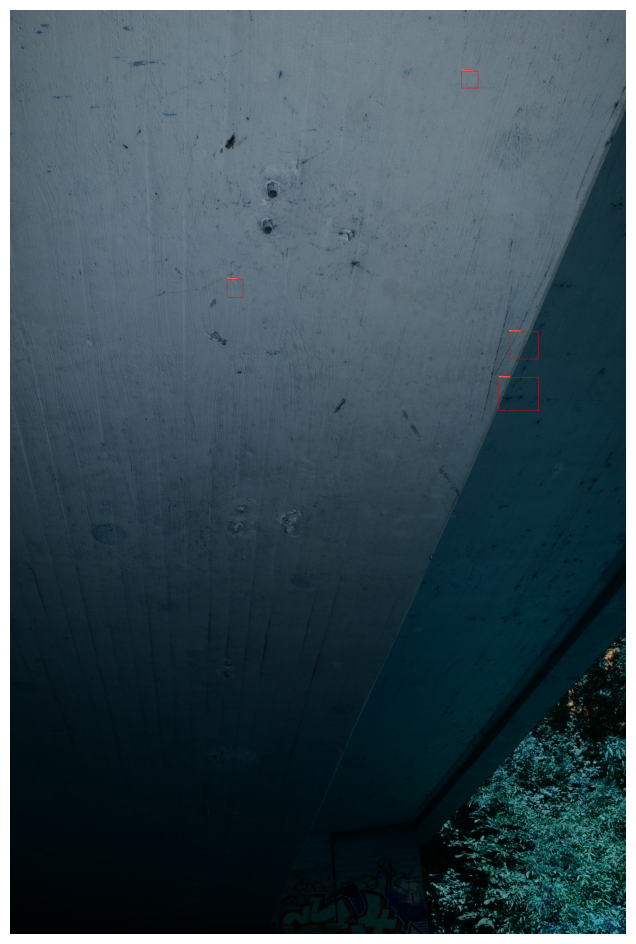

In [40]:
ann = random.choice(dim_issues)

img, bboxes, classes = get_bounding_boxes(ann)
image = cv2.imread(images_path / img)

print(image.shape)
view_image_bbox(image, bboxes)

## Dataset Statistics

In [24]:
dataset_stats

{'total_images': 919,
 'total_annotations': 4698,
 'annotations_per_class': Counter({'Crack': 1762,
          'Efflorescence': 968,
          'Spallation': 584,
          'Water': 490,
          'CorrosionStain': 464,
          'ExposedBars': 266,
          'Voids': 104,
          'Cavity': 60}),
 'avg_objects_per_image': np.float64(5.112078346028292),
 'min_bbox_width': np.int64(10),
 'max_bbox_width': np.int64(5997),
 'avg_bbox_width': np.float64(423.1064282673478),
 'min_bbox_height': np.int64(8),
 'max_bbox_height': np.int64(3953),
 'avg_bbox_height': np.float64(447.5427841634738),
 'min_bbox_area': np.int64(180),
 'max_bbox_area': np.int64(17763114),
 'avg_bbox_area': np.float64(302396.9169859515),
 'min_image_width': np.int64(806),
 'max_image_width': np.int64(6016),
 'avg_image_width': np.float64(3269.6996735582156),
 'min_image_height': np.int64(604),
 'max_image_height': np.int64(4000),
 'avg_image_height': np.float64(2470.480957562568)}

### Colour Distribution

In [29]:
imgs =[]

for filename in images:
    img_path = os.path.join(images_path, filename)
    img = cv2.imread(img_path)
    if img is not None:
        imgs.append(img)
len(imgs)

KeyboardInterrupt: 

In [42]:
color_dists = []

for img in imgs:
    color_dist = np.bincount(img.flatten(), minlength=256)
    color_dists.append(color_dist)
len(color_dists)

919

In [44]:
color_dists = np.array(color_dists)
type(color_dists)

numpy.ndarray

In [46]:
color_dists.shape

(919, 256)

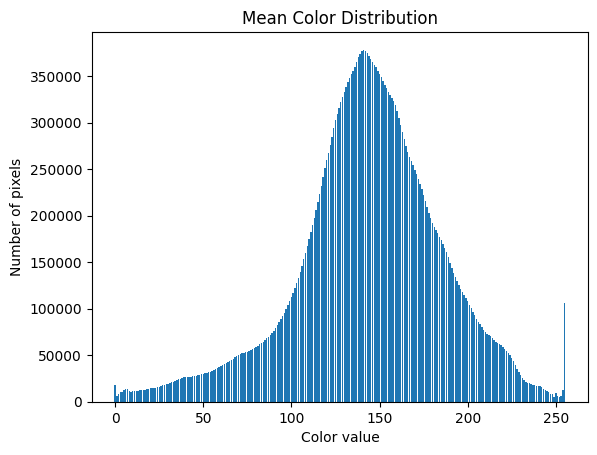

In [47]:
mean_color_dist = np.mean(color_dists, axis=0)

plt.bar(np.arange(256),mean_color_dist)
plt.title("Mean Color Distribution")
plt.xlabel("Color value")
plt.ylabel("Number of pixels")
plt.show()

### Plot Distribution 

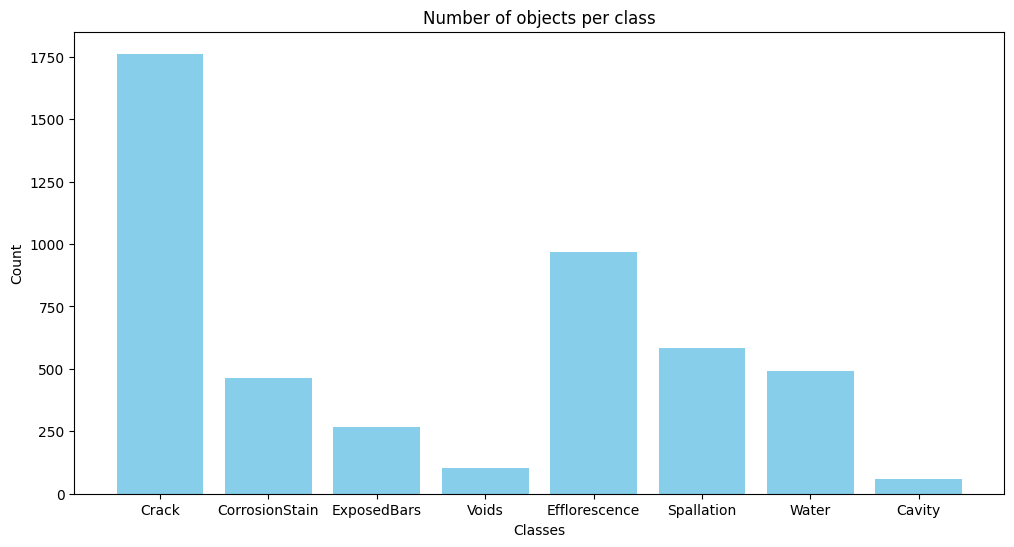

In [48]:
classes = list(class_count.keys())
values = list(class_count.values())

plt.figure(figsize=(12, 6))
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Number of objects per class")
plt.bar(classes, values, color="SKYBLUE")
plt.show()

### Objects per  Image

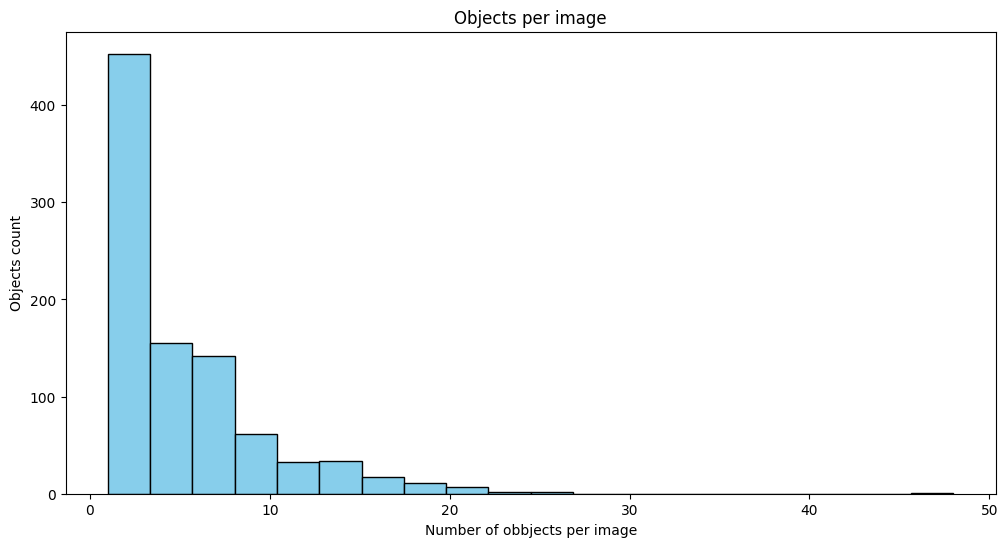

In [49]:
plt.figure(figsize=(12,6))
plt.xlabel("Number of obbjects per image")
plt.ylabel("Objects count")
plt.title("Objects per image")
plt.hist([item['objects'] for item in objects_per_image], bins=20, color="SKYBLUE",edgecolor='black')
plt.show()

### Plot Image Dimensions

919


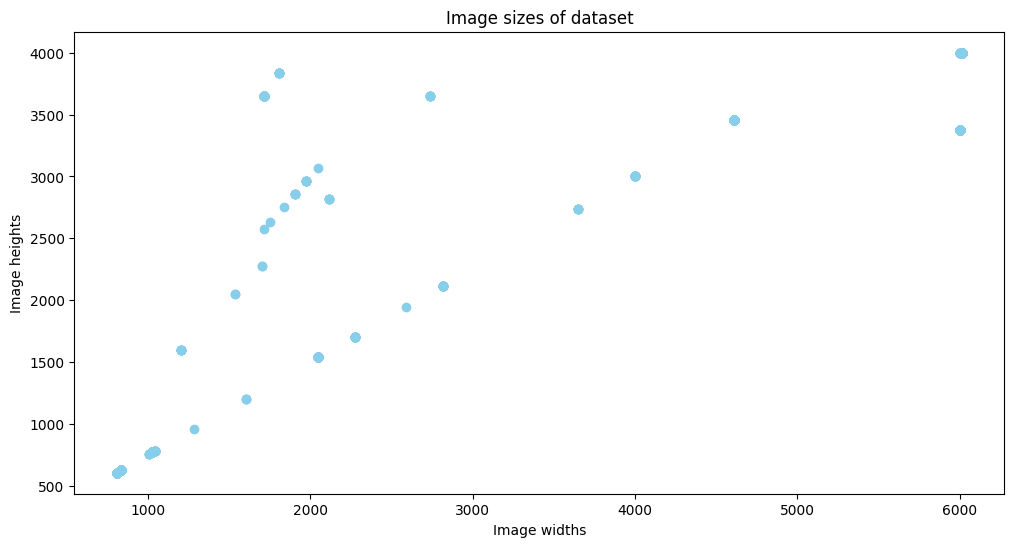

In [50]:

widths = image_dims[:,0]
heights = image_dims[:,1]
print(len(widths))

plt.figure(figsize=((12,6)))
plt.xlabel("Image widths")
plt.ylabel(("Image heights"))
plt.title("Image sizes of dataset")
plt.scatter(widths, heights, color="SKYBLUE")
plt.show()

plot analysis

Based on the plots and the insights they provide, here are the potential problems you might be facing and a corresponding augmentation pipeline using **Albumentations**:

### Problems Identified from Plots:
1. **Color Distribution** (Mean Color Distribution Plot):
   - The dataset may lack diversity in color. Augmentations that modify the color channels can help diversify the training data.

2. **Class Imbalance** (Number of objects per class):
   - Some classes have significantly fewer samples, which could cause the model to be biased towards the over-represented classes. Using class-specific augmentation to increase the under-represented class samples could help.

3. **Objects per Image** (Objects per image plot):
   - Most images have very few objects, with a long tail of images having many objects. Techniques like mosaic augmentation can help by combining multiple images with fewer objects into one.

4. **Image Sizes** (Image sizes plot):
   - The dataset has images of various sizes, which could be problematic for models that expect uniform input size. Scaling, padding, and resizing are essential to standardize input dimensions.

### Augmentation Pipeline using Albumentations

Here’s a sample pipeline tailored to address these issues:

```python
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define an augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        # 1. Random brightness and contrast changes (for color diversification)
        A.RandomBrightnessContrast(p=0.5),
        
        # 2. Hue, Saturation, and Value jitter (to vary colors and light conditions)
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        
        # 3. Mosaic augmentation (combine multiple images to artificially increase objects per image)
        A.Mosaic(p=0.5),
        
        # 4. Resize all images to a consistent size (e.g., 640x640 for uniformity)
        A.Resize(640, 640, p=1.0),
        
        # 5. Apply Horizontal flip (simple augmentation to increase diversity)
        A.HorizontalFlip(p=0.5),
        
        # 6. Random Crop (to deal with varying object sizes and focusing on small objects)
        A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5),
        
        # 7. Random rotation (rotate the images slightly to make the model robust to angles)
        A.Rotate(limit=15, p=0.5),
        
        # 8. Random scale and translation to simulate different image sizes
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.5),
        
        # 9. Add padding if necessary to maintain aspect ratios
        A.PadIfNeeded(min_height=640, min_width=640, border_mode=0, value=[0, 0, 0], p=1.0),
        
        # 10. Normalization (assuming a model pre-trained on ImageNet)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
        # 11. Convert to Tensor
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Example usage with a dataset
augmentation_pipeline = get_augmentation_pipeline()

# Apply augmentations to an example image and bounding boxes
# augmented = augmentation_pipeline(image=image, bboxes=bboxes, labels=labels)
```

### Augmentation Details:

1. **Color Augmentations**: 
   - **RandomBrightnessContrast** and **HueSaturationValue** will help diversify the color space to address the limited color variation shown in the first plot.

2. **Class-specific Augmentation**: 
   - For under-represented classes (like **ExposedBars**, **Cavity**, etc.), you can oversample those images and apply heavy augmentations like **Mosaic**, **RandomResizedCrop**, and **Rotate**.

3. **Handling Object Count per Image**:
   - **Mosaic augmentation** combines multiple images into one. This is useful to artificially create images with more objects, helping address the low object count in most images.

4. **Image Size Variability**:
   - **Resize** and **PadIfNeeded** ensure that all images are brought to the same size (e.g., 640x640), which helps when the model expects uniform input dimensions.

This pipeline should enhance your dataset and help alleviate the issues shown in the plots. Let me know if you need further adjustments!

## Augmentations

In [39]:
test_dir = Path("test")
tannotations_path = test_dir / "Annotations"
timages_path = test_dir / "Images"

### Helpers

In [40]:
def delete_files_with_prefix(directory_path, prefix):
    try:
        # List all files in the directory
        for filename in os.listdir(directory_path):
            # Construct the full file path
            file_path = os.path.join(directory_path, filename)
            # Check if it is a file and if it starts with the specified prefix
            if os.path.isfile(file_path) and filename.startswith(prefix):
                # Delete the file
                os.remove(file_path)
                print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Error: {e}")

In [41]:
def augment_image(image, bboxes,aug):
    """
    Apply a sequence of augmentations to an input image.
    :param image: Input image (numpy array)
    :param aug: Albumentations augmentation pipeline
    :return: Augmented image
    """
    augmented = aug(image=image, bboxes=bboxes)
    return augmented['image'], augmented["bboxes"]

In [88]:
def augment_class_images(annotation_class_files, annotations_path=annotations_path,images_path=images_path,num_augmentations=2, target_count=32):
   
    """
    input annotations shoudl all be of a certain class
    Apply augmentations to images in a class directory to balance the dataset.
    :param input_dir: Directory containing the class images
    :param output_dir: Directory to save the augmented images
    :param num_augmentations: Number of augmentations per image
    :param target_count: Target number of images for the class
    """

    current_count = len(annotation_class_files)

    aug = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(640, 640, p=1.0),    
    A.PadIfNeeded(min_height=640, min_width=640, border_mode=0, value=[0, 0, 0], p=1.0),
    ], bbox_params=A.BboxParams(format='pascal_voc'))

    rand_iters = int((target_count - current_count) / num_augmentations)
    annotation_class_files = random.sample(annotation_class_files, len(annotation_class_files))
    if rand_iters <= len(annotation_class_files):
        annotation_class_files = annotation_class_files[:rand_iters]

    for i,annotation_file in enumerate(tqdm(annotation_class_files)):

        # annotation_file = random.choice(annotation_class_files)
        # annotation_path = os.path.join(input_dir, annotation_file)
        img_filename, bboxes, classes = get_bounding_boxes(annotation_file)
        image = cv2.imread( images_path/ img_filename)

        tree = ET.parse(annotations_path/ annotation_file)
        root = tree.getroot()

        root.find("size/width").text = "640"
        root.find("size/height").text = "640"
        # print(img_filename)

        for j in range(num_augmentations):
            augmented_image, augmented_bboxes = augment_image(image, bboxes,aug)
            output_path = os.path.join(images_path, f"aug_{i}_{j}_{img_filename}")
            cv2.imwrite(output_path, augmented_image)

            

            root.find("filename").text = str(f"aug_{i}_{j}_{img_filename}")

            for obj, new_bbox in zip(root.findall("object"), augmented_bboxes):
                bbox = obj.find('bndbox')
                bbox.find('xmin').text = str(int(new_bbox[0]))
                bbox.find('ymin').text = str(int(new_bbox[1]))
                bbox.find('xmax').text = str(int(new_bbox[2]))
                bbox.find('ymax').text = str(int(new_bbox[3]))
            tree.write(os.path.join(annotations_path, f"aug_{i}_{j}_{annotation_file}"))

In [48]:
def get_classes_file_annotations_explicit(class_name, annotations_path=annotations_path):
    class_xml_files = []

    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith(".xml"):
            _, _b, class_names = get_bounding_boxes(xml_file, path_dir=annotations_path)
            if all(class_name == item for item in class_names):
                class_xml_files.append(xml_file)
    return class_xml_files, class_name

In [44]:
def get_classes_file_annotations(class_name, annotations_path=annotations_path):
    class_xml_files = []
    print(class_name)

    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith(".xml"):
            _, _b, class_names = get_bounding_boxes(xml_file, path_dir=annotations_path)
            if class_name in class_names:
                class_xml_files.append(xml_file)
    return class_xml_files, class_name

In [45]:
def delete_files_with_prefix(directory_path, prefix):
    try:
        # List all files in the directory
        for filename in os.listdir(directory_path):
            # Construct the full file path
            file_path = os.path.join(directory_path, filename)
            # Check if it is a file and if it starts with the specified prefix
            if os.path.isfile(file_path) and filename.startswith(prefix):
                # Delete the file
                os.remove(file_path)
                print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Error: {e}")

In [34]:
def get_originales(files):
    new_files = []
    for file in files:
        if not file.startswith("aug"):
            new_files.append(file)
    return new_files

In [46]:
def augment_class(class_name, ex=False, annotations_path=annotations_path, na=5):
    files = []
    if ex:
        files, _ = get_classes_file_annotations_explicit(annotations_path=annotations_path, class_name=class_name)
    else:
        files, _ = get_classes_file_annotations(annotations_path=annotations_path, class_name=class_name)
  
    augment_class_images(get_originales(files), annotations_path=annotations_path, images_path=images_path, num_augmentations=na)

### Check Annotations

In [91]:
# delete_files_with_prefix(images_path,prefix="aug")

In [92]:
len(os.listdir(annotations_path))

905

In [93]:
len(os.listdir(images_path))

905

## Augment dataset

In [96]:
class_count

Counter({'Crack': 1756,
         'Efflorescence': 946,
         'Spallation': 576,
         'Water': 490,
         'CorrosionStain': 461,
         'ExposedBars': 266,
         'Voids': 104,
         'Cavity': 60})

In [94]:
get_class_counts().total()

4659

In [95]:
len(os.listdir(images_path))

905

### Sample Caviity

In [97]:
augment_class("Cavity")

Cavity


100%|██████████| 48/48 [00:14<00:00,  3.39it/s]


In [98]:
get_class_counts().total()

7239

In [99]:
get_class_counts()

Counter({'Crack': 1956,
         'Efflorescence': 1766,
         'Water': 1310,
         'Spallation': 771,
         'CorrosionStain': 581,
         'Cavity': 340,
         'ExposedBars': 311,
         'Voids': 204})

In [100]:
len(os.listdir(images_path))

1145

### Sample Viods

In [101]:
augment_class("Voids")

Voids


100%|██████████| 39/39 [00:10<00:00,  3.55it/s]


In [102]:
get_class_counts()

Counter({'Efflorescence': 2566,
         'Crack': 2156,
         'Water': 1700,
         'Spallation': 876,
         'Voids': 719,
         'CorrosionStain': 686,
         'Cavity': 385,
         'ExposedBars': 371})

In [103]:
get_class_counts().total()

9459

In [104]:
len(os.listdir(images_path))

1340

### Sample ExposedBars

In [105]:
augment_class("ExposedBars")

ExposedBars


100%|██████████| 104/104 [00:31<00:00,  3.27it/s]


In [106]:
len(os.listdir(images_path))

1855

In [107]:
get_class_counts()

Counter({'Efflorescence': 2726,
         'Crack': 2536,
         'Water': 1935,
         'ExposedBars': 1541,
         'Spallation': 1071,
         'CorrosionStain': 1026,
         'Voids': 764,
         'Cavity': 430})

### Sample Corrosion

In [108]:
augment_class("CorrosionStain")

CorrosionStain


100%|██████████| 162/162 [01:23<00:00,  1.95it/s]


In [109]:
get_class_counts()

Counter({'Crack': 3981,
         'Efflorescence': 3866,
         'CorrosionStain': 3001,
         'Water': 2600,
         'ExposedBars': 1841,
         'Spallation': 1501,
         'Voids': 814,
         'Cavity': 500})

In [110]:
get_class_counts().total()

18104

In [111]:
len(os.listdir(images_path))

2660

### Sample Spallation

In [112]:
augment_class("Spallation")

Spallation


100%|██████████| 205/205 [02:01<00:00,  1.69it/s]


In [113]:
get_class_counts()

Counter({'Efflorescence': 5111,
         'Crack': 5096,
         'Spallation': 3781,
         'CorrosionStain': 3411,
         'Water': 3345,
         'ExposedBars': 2181,
         'Voids': 914,
         'Cavity': 610})

In [114]:
get_class_counts().total()

24449

In [115]:
len(os.listdir(images_path))

3685

### Sanity Check

In [116]:
dim_issues = []

for ann in os.listdir(annotations_path):
    if ann.endswith(".xml"):
        img, bboxes, img_dims = get_bboxes_and_img_dims(annotations_path,ann)

        for bbox in bboxes:
            if not cross_validate_dims(img,img_dims=img_dims):
                dim_issues.append(ann)

[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)
[640, 640]
(640, 640, 3)


In [117]:
dim_issues

[]

In [118]:
bbox_issues = []

for ann in os.listdir(annotations_path):
    print(ann)
    if ann.endswith(".xml"):
        img, bboxes, img_dims = get_bboxes_and_img_dims(annotations_path,ann)

        for bbox in bboxes:
            if not is_voc_bbox_valid(bbox, img_dims[0], img_dims[1]):
                bbox_issues.append(ann)

aug_23_3_image_0002106.xml
aug_110_4_image_0001355.xml
aug_51_1_image_0002452.xml
aug_185_1_image_0002290.xml
aug_2_2_image_0002376.xml
aug_31_4_image_0002307.xml
aug_130_2_image_0002327.xml
aug_13_3_image_0001576.xml
aug_52_0_image_0001361.xml
aug_6_4_image_0002303.xml
aug_27_0_image_0002414.xml
aug_30_0_image_0002288.xml
image_0001237.xml
aug_150_4_image_0002359.xml
image_0002058.xml
aug_2_0_image_0002473.xml
image_0001223.xml
aug_28_4_image_0002273.xml
aug_74_0_image_0002239.xml
image_0002064.xml
aug_21_4_image_0000410.xml
aug_198_4_image_0002492.xml
image_0000667.xml
image_0002070.xml
aug_43_0_image_0002423.xml
aug_196_0_image_0002182.xml
image_0002299.xml
aug_141_1_image_0001342.xml
aug_8_2_image_0001153.xml
aug_34_0_image_0002270.xml
aug_161_2_image_0001438.xml
aug_35_1_image_0002101.xml
aug_52_2_image_0002390.xml
aug_8_3_image_0002306.xml
aug_85_4_image_0002363.xml
aug_89_4_image_0002265.xml
aug_105_2_image_0002106.xml
aug_192_4_image_0002427.xml
aug_173_3_image_0002197.xml
aug_

In [119]:
bbox_issues

[]

## Make YOLO dataset

In [24]:
annotations_path

PosixPath('bridge_dataset/Annotations')

In [26]:
from pylabel import importer

dataset = importer.ImportVOC(annotations_path, name="Bridge_vision")
dataset.df.head(5)

Importing VOC files...: 100%|██████████| 3685/3685 [00:02<00:00, 1825.29it/s]


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,.,aug_23_3_image_0002106.jpg,NaN,0,640,640,3,0,58.0,425.0,...,NaN,NaN,Unspecified,0,0,0,Water,NaN,,1
1,.,aug_23_3_image_0002106.jpg,NaN,0,640,640,3,0,310.0,425.0,...,NaN,NaN,Unspecified,0,0,0,Water,NaN,,1
2,.,aug_23_3_image_0002106.jpg,NaN,0,640,640,3,0,101.0,342.0,...,NaN,NaN,Unspecified,0,0,1,Spallation,NaN,,1
3,.,aug_23_3_image_0002106.jpg,NaN,0,640,640,3,0,478.0,265.0,...,NaN,NaN,Unspecified,0,0,2,ExposedBars,NaN,,1
4,.,aug_23_3_image_0002106.jpg,NaN,0,640,640,3,0,426.0,242.0,...,NaN,NaN,Unspecified,0,0,2,ExposedBars,NaN,,1


In [27]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 3684
Number of classes: 8
Classes:['Water', 'Spallation', 'ExposedBars', 'Crack', 'CorrosionStain', 'Efflorescence', 'Voids', 'Cavity']
Class counts:
cat_name
Efflorescence     5111
Crack             5096
Spallation        3781
CorrosionStain    3411
Water             3345
ExposedBars       2181
Voids              914
Cavity             610
Name: count, dtype: int64


In [28]:
dataset.splitter.GroupShuffleSplit(train_pct=.75, val_pct=.15, test_pct=.1)
dataset.analyze.ShowClassSplits()

,all,train,test,val
cat_name,,,,


In [ ]:
dataset.export.ExportToYoloV5(output_path='model_training/labels',yaml_file='dataset.yaml', copy_images=True, use_splits=True)